In [17]:
# Imports:
!pip install pytesseract
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 17 not upgraded.


In [45]:
import nltk

nltk.download("wordnet")
nltk.download("words")
from nltk.corpus import wordnet as wn
from nltk.corpus import words as words
import pytesseract
import numpy as np
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [33]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
def lexnames(word):
    """
    Returns the list of figures of speech of (word).
    Example: adj.all
    """
    syns = wn.synsets(str(word))
    list_lexnames = []
    for syn in syns:
        if syn.lexname() not in list_lexnames:
            list_lexnames.append(syn.lexname())
    return list_lexnames

In [35]:
# Getting the weights for each figure of speech
weights = pd.read_csv("/content/drive/MyDrive/Subex/weights.csv", index_col=0)
weights = weights.to_dict("r")
weighted = weights[0]

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:1490: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  FutureWarning,


In [36]:
def find_weighted_sum(sentence):

    lexical_list = {}
    j = sentence.split()
    fos = {}
    for k in j:
        result = lexnames(k)
        for word in result:
            if word not in fos:
                fos[word] = 1
            else:
                fos[word] += 1
        try:
            if k[0] is "$" or float(k) or int(k):
                if "noun.quantity" not in fos:  # Appending noun.quantity for numerals;
                    # Since lexnames does not do so sometimes
                    fos["noun.quantity"] = 1
                else:
                    fos["noun.quantity"] += 1
        except:
            continue
            # print(f"{k} is not a numeral")
    lexical_list[sentence] = fos
    weighted_sum = 0
    for i in lexical_list.keys():
        for j in lexical_list[i].keys():
            # print(j)
            if j in weighted.keys():
                # print(f"Weight for {j} found!")
                weighted_sum += weighted[j] * lexical_list[i][j]
            else:
                continue
                # print(f"Weight for {j} not found!")
    return weighted_sum

In [37]:
def preprocess_pytesseract_string(data):
    data = data.split("\n")
    list_of_items = []
    for i in data:
        j = i.split()
        if len(j) != 0:
            try:
                if j[-1][0] == "$" or float(j[-1]) or int(j[-1]):
                    list_of_items.append(i)
            except Exception as e:
                # print(e)
                continue
    return list_of_items

In [41]:
def create_and_check_contours(img, method=1):
    final_data = {}
    # Thresholding the image
    img_copy = img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kernel = np.array([[-1, -1, -1], [-1, 10, -1], [-1, -1, -1]])
    img = cv2.filter2D(img, -1, kernel)
    (thresh, img_bin) = cv2.threshold(
        img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU
    )  # Invert the image
    img_bin = 255 - img_bin
    # Defining a kernel length
    kernel_length = np.array(img).shape[1] // 80
    # A vertical kernel of (1 X kernel_length), which will detect all the vertical lines from the image.
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))
    # A horizontal kernel of (kernel_length X 1), which will help to detect all the horizontal line from the image.
    hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))
    # A kernel of (3 X 3) ones.
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    # Morphological operation to detect vertical lines from an image
    # path = '/content/drive/MyDrive/Subex/temporary/'
    img_temp1 = cv2.erode(img_bin, vertical_kernel, iterations=3)
    vertical_lines_img = cv2.dilate(img_temp1, vertical_kernel, iterations=3)
    # cv2.imwrite(path + "vertical_lines.jpg",vertical_lines_img)
    # Morphological operation to detect horizontal lines from an image
    img_temp2 = cv2.erode(img_bin, hori_kernel, iterations=3)
    horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=3)
    # cv2.imwrite(path + "horizontal_lines.jpg",horizontal_lines_img)

    # Weighting parameters, this will decide the quantity of an image to be added to make a new image.
    alpha = 0.5
    beta = 1.0 - alpha
    # This function helps to add two image with specific weight parameter to get a third image as summation of two image.
    img_final_bin = cv2.addWeighted(
        vertical_lines_img, alpha, horizontal_lines_img, beta, 0.0
    )
    img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)
    (thresh, img_final_bin) = cv2.threshold(
        img_final_bin, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU
    )
    # cv2.imwrite(path + "img_final_bin.jpg",img_final_bin)

    contours, hierarchies = cv2.findContours(
        img_final_bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE
    )
    print(f"{len(contours)} contours found")

    sizes = []
    for i in range(len(contours)):

        x, y, w, h = cv2.boundingRect(contours[i])
        i = cv2.rectangle(
            img_copy.copy(), (x, y), (x + w, y + h), (0, 255, 0), thickness=5
        )
        cimg = img_copy[y : y + h, x : x + w]
        if method == 2:
            cimg = cv2.cvtColor(cimg, cv2.COLOR_BGR2GRAY)
            cimg = cv2.resize(cimg, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
            (_, cimg) = cv2.threshold(cimg, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
            sharp_kernel = np.array([[-1, -1, -1], [-1, 10, -1], [-1, -1, -1]])
            cimg = cv2.filter2D(cimg, -1, sharp_kernel)
            kernel = np.ones((2, 2))
            cimg = 255 - cimg
            data = pytesseract.image_to_string(cimg)
            data_list = preprocess_pytesseract_string(data)
            sentence_dict = {}
            cumulative_score = 0
            for sentence in data_list:
                sentence_dict[sentence] = find_weighted_sum(sentence)
                if sentence_dict[sentence] >= 50:
                    cumulative_score += 1
            if len(sentence_dict) != 0:
                final_data[(x, y, w, h, w * h, cumulative_score)] = sentence_dict
            else:
                continue
        else:
            data = pytesseract.image_to_string(cimg)
            counter = 0
            data_list = preprocess_pytesseract_string(data)
            sentence_dict = {}
            cumulative_score = 0
            for sentence in data_list:
                sentence_dict[sentence] = find_weighted_sum(sentence)
                if sentence_dict[sentence] >= 50:
                    cumulative_score += 1
            if len(sentence_dict) != 0:
                final_data[(x, y, w, h, w * h, cumulative_score)] = sentence_dict
            else:
                continue
    return final_data

In [56]:
def obtain_significant_contour(result):
    flag = 0
    for i in result.keys():
        if i[5] > flag:
            rm = {}
            flag = i[5]
            rm[i] = result[i]
    return rm

In [57]:
filename = "/content/drive/MyDrive/Subex/Subex Hackathon Dataset/images/00069.PNG"
img = cv2.imread(filename)
result_method_1 = create_and_check_contours(img, 1)
rm1 = obtain_significant_contour(result_method_1)
(xmin, ymin, xmax, ymax, _, _) = list(rm1)[0]
img = cv2.imread(filename)
img_re = cv2.rectangle(
    img, (xmin, ymin), (xmin + xmax, ymin + ymax), color=(0, 255, 0), thickness=2
)

34 contours found


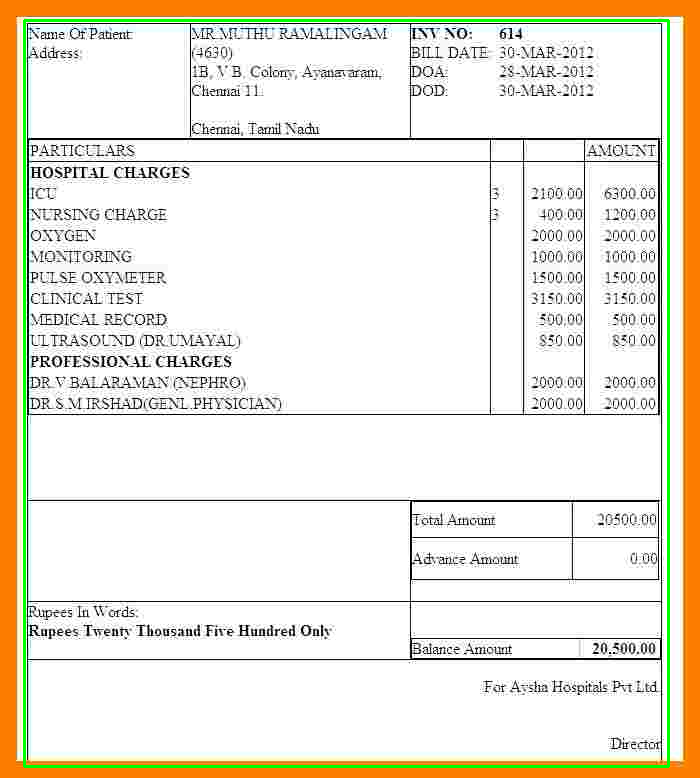

In [53]:
rm1

{(0, 0, 700, 778, 544600, 0): {'$0.00]': 10.638297872340424,
  '$50.00': 10.638297872340424,
  '1000.06': 10.638297872340424,
  '1890.00': 10.638297872340424,
  '2000.00': 10.638297872340424,
  '3150.00': 10.638297872340424,
  '400.00': 10.638297872340424,
  '6.09': 10.638297872340424,
  '[NVNO: 614': 10.638297872340424,
  '|Chennai 11': 29.787234042553187}}

In [67]:
def final_result(filename):

    """
    Applies all the functions defined above and
    returns the contour value, the data in that
    contour, and the image with the contour
    drawn over it.
    """

    img = cv2.imread(filename)
    result_method_1 = create_and_check_contours(img, 1)
    rm1 = obtain_significant_contour(result_method_1)
    contour_value = next(iter(rm1))
    print(contour_value)
    print(result_method_1[contour_value])
    (xmin, ymin, xmax, ymax, _, _) = list(rm1)[0]
    img = cv2.imread(filename)
    img_re = cv2.rectangle(
        img, (xmin, ymin), (xmin + xmax, ymin + ymax), color=(0, 255, 0), thickness=2
    )
    cv2_imshow(img_re)

34 contours found
(24, 20, 644, 746, 480424, 2)
{'(Chennai 11': 29.787234042553187, 'NURSING CHARGE E 400.00) 1206.00': 91.48936170212764, 'MONTIORING 1900.00) 1000.00': 10.638297872340424, 'PULSE OXYMETER 1500.00) 1500.00': 20.212765957446805, 'MEDICAL RECORD $00.00)': 58.51063829787233}


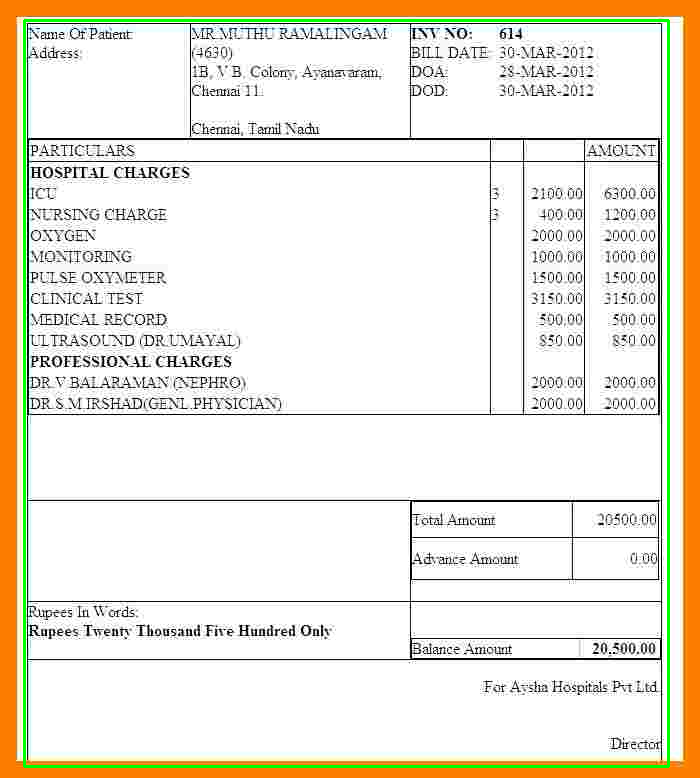

In [68]:
final_result(filename)